# Learning 1d Pure Advection in Conservative Form

To verify that our PINN implementation is working well, we test the PINN on the following problem:
$$
    \begin{cases}
        u_t + a(t)u_x = 0\\
        \lim_{|x|\rightarrow\infty}u(t, x) = 0\\
        u(0, x) = u_0(x)
    \end{cases}
$$ where $u_0 = \mathcal{N}(x|0, 1)$. 

In this case, the NN solution is assumed to have the following model (conservative advection):
$$
    \frac{\partial u_{\theta_1}}{\partial t} + \frac{\partial}{\partial x}\bigg(\mathcal{V}_{\theta_2}(t)u_{\theta_1}\bigg) = 0
$$

In this test case, the true advection velocity is a time-varying function, no spatial dependence. Furthermore, since the coefficient neural network is a time-dependent function, the conservative and non-conservative form of the PDE coincide. In this notebook, we generate data from such a PDE and test the PINN learning in both conservative mode and non-conservative mode.

In [2]:
from PINN.AdvectionNet import *
# Testing
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy

# set random seeds
np.random.seed(10)
torch.manual_seed(10);

import numpy as np    
import matplotlib.pyplot as plt

import time
import pylab as pl
from IPython import display
from IPython.display import clear_output

# Experiment 1: High Frequency with Vanilla NN

Consider the following PDE, taken from: https://scullen.com.au/DSc/Publications/scullen_92.pdf (Page 44)

$$
    \frac{\partial u}{\partial t} + v_0\sin(\omega t)\frac{\partial u}{\partial x} = 0
$$ which admits an analytical solution:
$$
    u(t,x) = \exp\bigg(
        -k[x - x_0 - 2v_0\omega^{-1}\sin^2(\frac{1}{2}\omega t)]^2
    \bigg)
$$ with parameters $k, x_0$ from the initial condition.

**This experiment should not work well**.

In [3]:
# parameters
x0 = 2.0
v0 = 2.0
k = 5.0
omega = 2.0*np.pi
# time grid
t_start = 0.0
t_end = 2*np.pi
dt = 0.001
tgrid = np.arange(t_start, t_end, dt)
nt = len(tgrid)
# spatial grid
x_left, x_right = 0.0, 5.0
dx = 0.005
xgrid = np.arange(x_left, x_right, dx)
nx = len(xgrid)

# solution
u_sol = np.zeros([nt, nx])
for i in range(nt):
    t = tgrid[i]
    u_sol[i, :] = np.exp(-k * (( xgrid - x0 ) - (2*v0/omega) * (np.sin(0.5*omega*t) ** 2)) ** 2 )

In [ ]:
# visualize solution over time
visualize = False
if visualize:
    for i in range(nt):
        plt.figure(1);
        if i % 50 == 0:
            plt.plot(xgrid, u_sol[i, :], color="red");
            plt.title(r"$t = {}$".format(i*dt));
            display.clear_output(wait=True);
            display.display(pl.gcf());
            plt.clf();
            time.sleep(0.01);

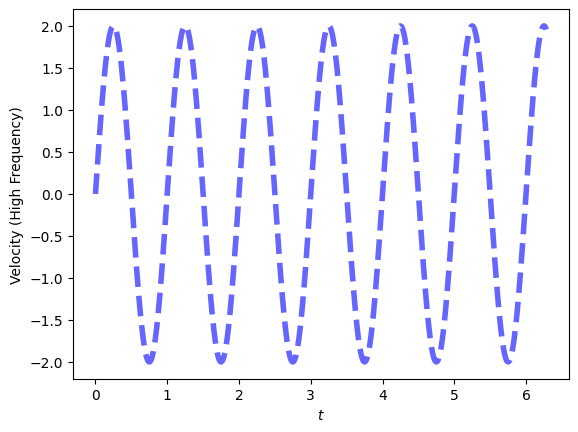

In [7]:
# plot velocity as a function of time
plt.figure(2);
plt.plot(tgrid, v0*np.sin(omega*tgrid), "--", color="blue", alpha=0.6, lw=4.0);
plt.xlabel(r"$t$"); plt.ylabel(r"Velocity (High Frequency)");

In [18]:
# save data for PINN training
scipy.io.savemat("../data/LinearOscillator/Time_Variable_Advection.mat", {
    "xgrid": xgrid.reshape(1, -1),
    "tgrid": tgrid.reshape(1, -1),
    "pmc": u_sol
})

# save a smaller dataset
subsample_t = 6
subsample_x = 2
xgrid_small = xgrid.reshape(1, -1)[:, 0:-1:subsample_x].squeeze(),
tgrid_small = tgrid.reshape(1, -1)[:, 0:-1:subsample_t].squeeze()
u_sol_small = u_sol[0:-1:subsample_t, 0:-1:subsample_x]
scipy.io.savemat("../data/LinearOscillator/Time_Variable_Advection_small.mat", {
    "xgrid": xgrid_small,
    "tgrid": tgrid_small,
    "pmc": u_sol_small
})
print("Training data size = {}\n".format(u_sol_small.shape))

Training data size = (1048, 500)



In [ ]:
# PINN experiments
data_path = "../data/LinearOscillator/Time_Variable_Advection_small.mat"
# create PINN
pinn = AdvectionNet(indim=2, outdim=1, data_path=data_path, scheduler="ExponentialLR", coef_mode="time")
# testing training
info = train(
    pinn, pinn.optimizer, pinn.scheduler, batch_size=2**10,
    epochs=200, batch_print=200, mode="all", conservative_pde=True
)

------------------------------------------------------------

=> Data Loaded at: ../data/LinearOscillator/Time_Variable_Advection_small.mat 

----> Total Number of observations = 521406 

------------------------------------------------------------

------------------------------------------------------------------

|                      Epoch 1                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

---------- 

++ Learning rate reduced, now at = 0.000980
Batch PDE Loss = 0.0005750248801431159 

Batch Data Loss = 0.02735933409090421 

------------------------------------------------------------------

|                      Epoch 2                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

---------- 

++ Learning rate reduced, now at = 0.000970
Batch PDE Loss = 0.00047432130070

| => | Batch 201 |

| => | Batch 401 |

---------- 

++ Learning rate reduced, now at = 0.000802
Batch PDE Loss = 0.0013189416086046046 

Batch Data Loss = 0.017911945721505493 

------------------------------------------------------------------

|                      Epoch 22                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

---------- 

++ Learning rate reduced, now at = 0.000794
Batch PDE Loss = 0.0013581536211505587 

Batch Data Loss = 0.01777227537527081 

------------------------------------------------------------------

|                      Epoch 23                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

---------- 

++ Learning rate reduced, now at = 0.000786
Batch PDE Loss = 0.001381693646675525 

Batch Data Loss = 0.017684200915569454 

---------------------

| => | Batch 201 |

| => | Batch 401 |

---------- 

++ Learning rate reduced, now at = 0.000649
Batch PDE Loss = 0.001794116541952217 

Batch Data Loss = 0.01595225732594701 

------------------------------------------------------------------

|                      Epoch 43                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

---------- 

++ Learning rate reduced, now at = 0.000643
Batch PDE Loss = 0.0017582715221966174 

Batch Data Loss = 0.015956863953185227 

------------------------------------------------------------------

|                      Epoch 44                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

---------- 

++ Learning rate reduced, now at = 0.000636
Batch PDE Loss = 0.001754233136587053 

Batch Data Loss = 0.01579978932130311 

-----------------------

| => | Batch 201 |

| => | Batch 401 |

---------- 

++ Learning rate reduced, now at = 0.000526
Batch PDE Loss = 0.00201143752839242 

Batch Data Loss = 0.0152157166072439 

------------------------------------------------------------------

|                      Epoch 64                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

---------- 

++ Learning rate reduced, now at = 0.000520
Batch PDE Loss = 0.001975241012340755 

Batch Data Loss = 0.015113220196091622 

------------------------------------------------------------------

|                      Epoch 65                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

---------- 

++ Learning rate reduced, now at = 0.000515
Batch PDE Loss = 0.0019980814703730748 

Batch Data Loss = 0.015164686569014577 

------------------------

| => | Batch 201 |

| => | Batch 401 |

---------- 

++ Learning rate reduced, now at = 0.000426
Batch PDE Loss = 0.0020376238300608774 

Batch Data Loss = 0.014691033540610712 

------------------------------------------------------------------

|                      Epoch 85                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

---------- 

++ Learning rate reduced, now at = 0.000421
Batch PDE Loss = 0.0020555070533172684 

Batch Data Loss = 0.014607324487832305 

------------------------------------------------------------------

|                      Epoch 86                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

---------- 

++ Learning rate reduced, now at = 0.000417
Batch PDE Loss = 0.002075237427108227 

Batch Data Loss = 0.014580557461446968 

--------------------